In [1]:
import pathlib
from IPython.display import Code

import RATapi as RAT

[IMAGES!]

# Simple example of a layer containing domains using a custom XY model

Domains custom XY models operate in the same way as domains custom layer models, in that there is an additional input to the custom model specifying the domain to be calculated:

This is then used within the function to calculate the correct SLD profile for each contrast and domain. In this example, we simulate a hydrogenated layer on a silicon substrate, containing domains of a larger SLD, against D2O, SMW and water.

Start by making the project and adding the parameters:

In [2]:
problem = RAT.Project(calculation="domains", model="custom xy", geometry="substrate/liquid")

problem.parameters.append(name="Oxide Thickness", min=10.0, value=20.0, max=50.0, fit=True)
problem.parameters.append(name="Layer Thickness", min=1.0, value=30.0, max=500.0, fit=True)
problem.parameters.append(name="Layer SLD", min=-0.5e-6, value=-0.5e-6, max=0.0, fit=True)
problem.parameters.append(name="Layer Roughness", min=2.0, value=5.0, max=7.0, fit=True)
problem.parameters.append(name="Domain SLD", min=1.0e-6, value=1.0e-6, max=5.0e-6, fit=True)

Now set the SLDs of the bulk phases for our samples.

In [3]:
problem.bulk_in.set_fields(0, name="Silicon", value=2.073e-6, max=1.0, fit=False)

problem.bulk_out.append(name="SLD SMW", min=2.0e-6, value=2.073e-6, max=2.1e-6)
problem.bulk_out.append(name="SLD H2O", min=-0.6e-6, value=-0.56e-6, max=-0.5e-6)

problem.scalefactors.set_fields(0, min=0.8, value=1.0, max=1.1, fit=True)

The custom file takes the parameters and build the model as usual, changing the SLD of the layer depending on whether we are calculating the layer (domain = 1), or the domain (domain = 2).

In [4]:
Code("domains_XY_model.py")

import math

import numpy as np


def domains_XY_model(params, bulk_in, bulk_out, contrast, domain):
    # Split up the parameters for convenience
    subRough = params[0]
    oxideThick = params[1]
    layerThick = params[2]
    layerSLD = params[3]
    layerRough = params[4]
    domainSLD = params[5]

    # Make an array of z values for our model
    z = np.arange(0, 141)

    # Make the volume fraction distribution for our Silicon substrate
    [vfSilicon, siSurf] = makeLayer(z, -25, 50, 1, subRough, subRough)

    # ... and the Oxide ...
    [vfOxide, oxSurface] = makeLayer(z, siSurf, oxideThick, 1, subRough, subRough)

    # ... and also our layer.
    [vfLayer, laySurface] = makeLayer(z, oxSurface, layerThick, 1, subRough, layerRough)

    # Everything that is not already occupied will be filled will water
    totalVF = vfSilicon + vfOxide + vfLayer
    vfWater = 1 - totalVF

    # Now convert the Volume Fractions to SLDs
    siSLD = vfSilicon * bulk_in
    oxSLD = vfOxide * 3.41e-6

    # Layer SLD depends on whether we are calculating the domain or not
    if domain == 0:
        laySLD = vfLayer * layerSLD
    else:
        laySLD = vfLayer * domainSLD

    # ... and finally the water SLD.
    waterSLD = vfWater * bulk_out[contrast]

    # Make the total SLD by just adding them all up
    totalSLD = siSLD + oxSLD + laySLD + waterSLD

    # The output is just a [n x 2] array of z against SLD
    SLD = np.column_stack([z, totalSLD])

    return SLD, subRough


def makeLayer(z, prevLaySurf, thickness, height, Sigma_L, Sigma_R):
    """This produces a layer, with a defined thickness, height and roughness.
    Each side of the layer has its own roughness value.
    """
    # Find the edges
    left = prevLaySurf
    right = prevLaySurf + thickness

    # Make our heaviside
    a = (z - left) / ((2**0.5) * Sigma_L)
    b = (z - right) / ((2**0.5) * Sigma_R)

    erf_a = np.array([math.erf(value) for value in a])
    erf_b = np.array([math.erf(value) for value in b])

    VF = np.array((height / 2) * (erf_a - erf_b))

    return VF, right

Finally, add the custom file to the project, and make our three contrasts.

In [5]:
problem.custom_files.append(name="Domain Layer", filename="domains_XY_model.py", language="python", path=pathlib.Path.cwd().resolve())

# Make contrasts
problem.contrasts.append(
    name="D2O",
    background="Background 1",
    resolution="Resolution 1",
    scalefactor="Scalefactor 1",
    bulk_in="Silicon",
    bulk_out="SLD D2O",
    domain_ratio="Domain Ratio 1",
    data="Simulation",
    model=["Domain Layer"],
)

problem.contrasts.append(
    name="SMW",
    background="Background 1",
    resolution="Resolution 1",
    scalefactor="Scalefactor 1",
    bulk_in="Silicon",
    bulk_out="SLD SMW",
    domain_ratio="Domain Ratio 1",
    data="Simulation",
    model=["Domain Layer"],
)

problem.contrasts.append(
    name="H2O",
    background="Background 1",
    resolution="Resolution 1",
    scalefactor="Scalefactor 1",
    bulk_in="Silicon",
    bulk_out="SLD H2O",
    domain_ratio="Domain Ratio 1",
    data="Simulation",
    model=["Domain Layer"],
)

Finally, run the simulation and plot the results.

Starting RAT ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Elapsed time is 0.049 seconds

Finished RAT ───────────────────────────────────────────────────────────────────────────────────────────────────────────



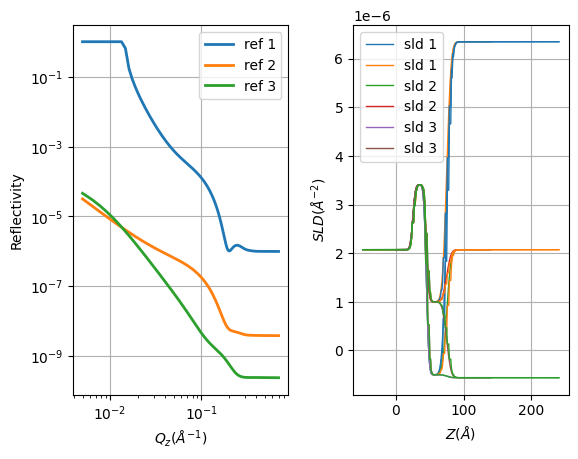

In [6]:
controls = RAT.Controls()
problem, results = RAT.run(problem, controls)

RAT.plotting.plot_ref_sld(problem, results)